## Using Epydemix and Approximate Bayesian Computation for Model Calibration

In this notebook we do a quick overview of the [epydemix](https://github.com/ngozzi/epydemix) Python package, with a focus on its functionalities aimed at model calibration with ABC methods.

In [ ]:
from epydemix import EpiModel
from epydemix.population import load_epydemix_population

First, we create a simple SIR model and we apply it to the United States population:

In [2]:
# create SIR model 
model = EpiModel(compartments=['S', 'I', 'R'])

# add transitions
model.add_transition('S', 'I', params=("beta", "I"), kind="mediated")
model.add_transition('I', 'R', params="mu", kind="spontaneous")

# parameters 
model.add_parameter(parameters_dict={"beta": 0.05, "mu": 0.1})

# add population 
population = load_epydemix_population("United_States")
model.set_population(population)

print(model)

EpiModel(name='EpiModel')
Compartments: 3
  S, I, R
Transitions: 2
  Transitions between compartments:
    S -> I, params: ('beta', 'I') (kind: mediated)
    I -> R, params: mu (kind: spontaneous)
Parameters: 2
  Model parameters:
    beta: 0.05
    mu: 0.1
Population: United_States
  Population size: 344479528 individuals
  Demographic groups: 5
    0-4, 5-19, 20-49, 50-64, 65+



We can plot population distribution and contact matrices:

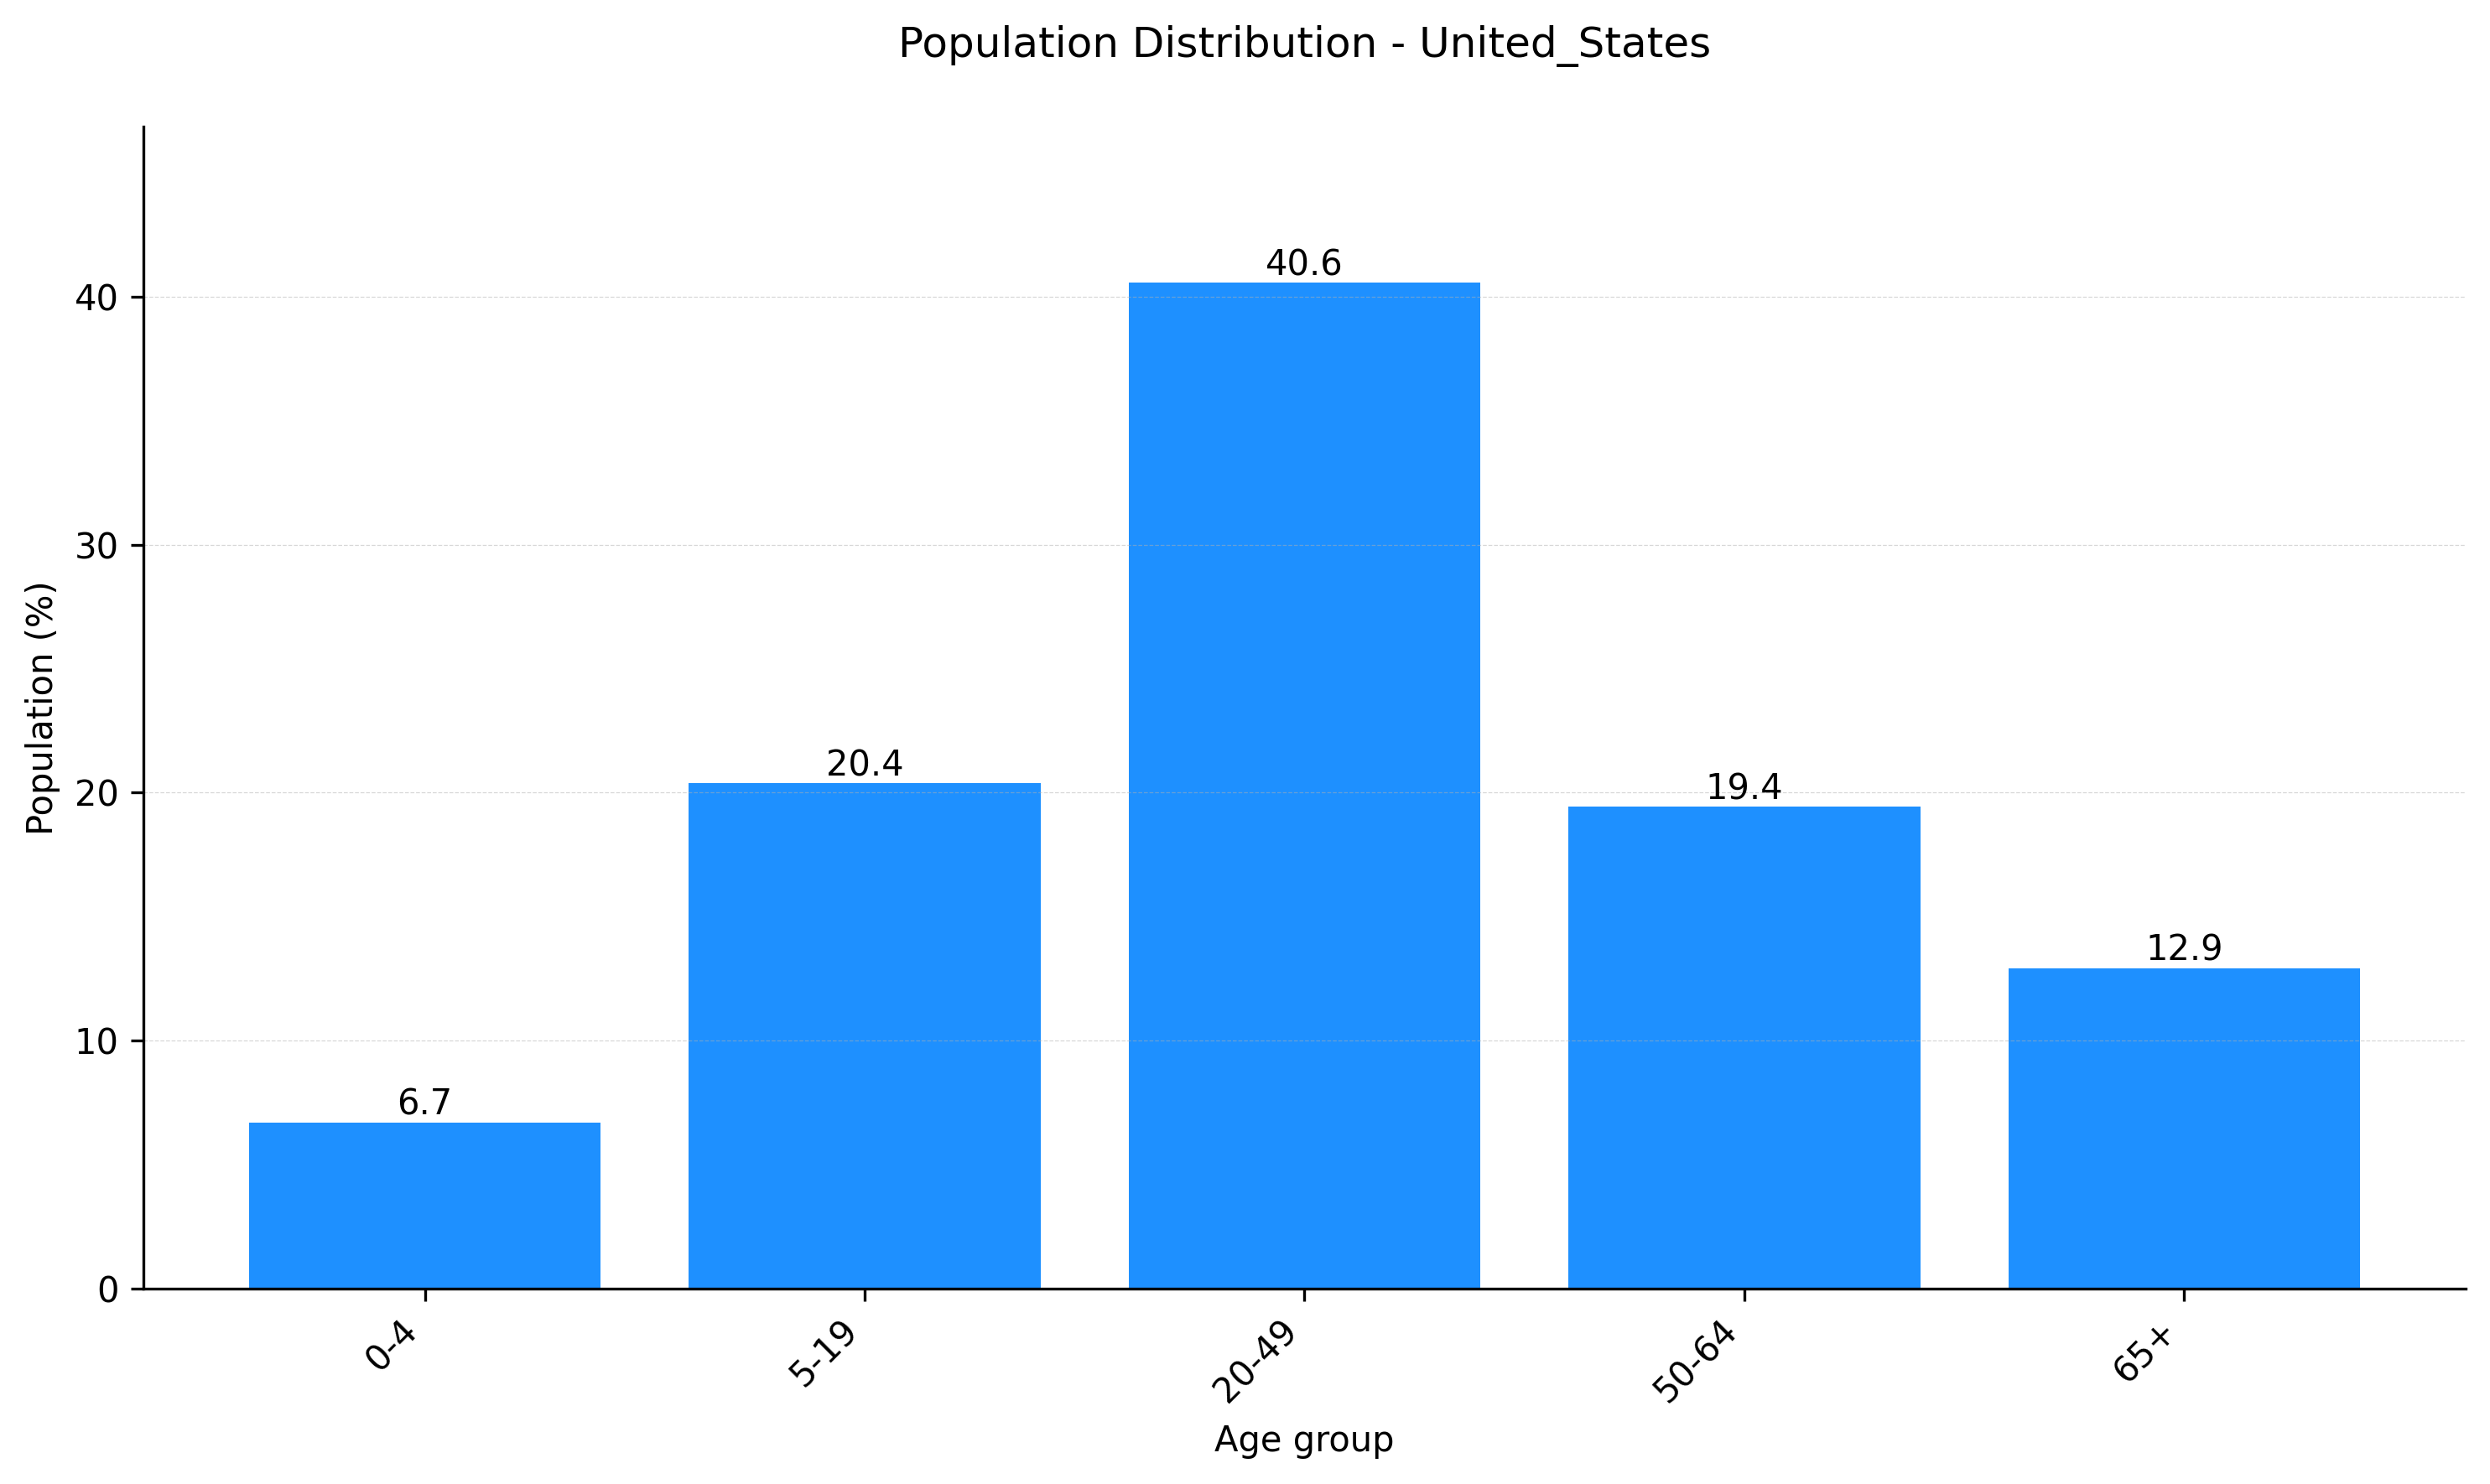

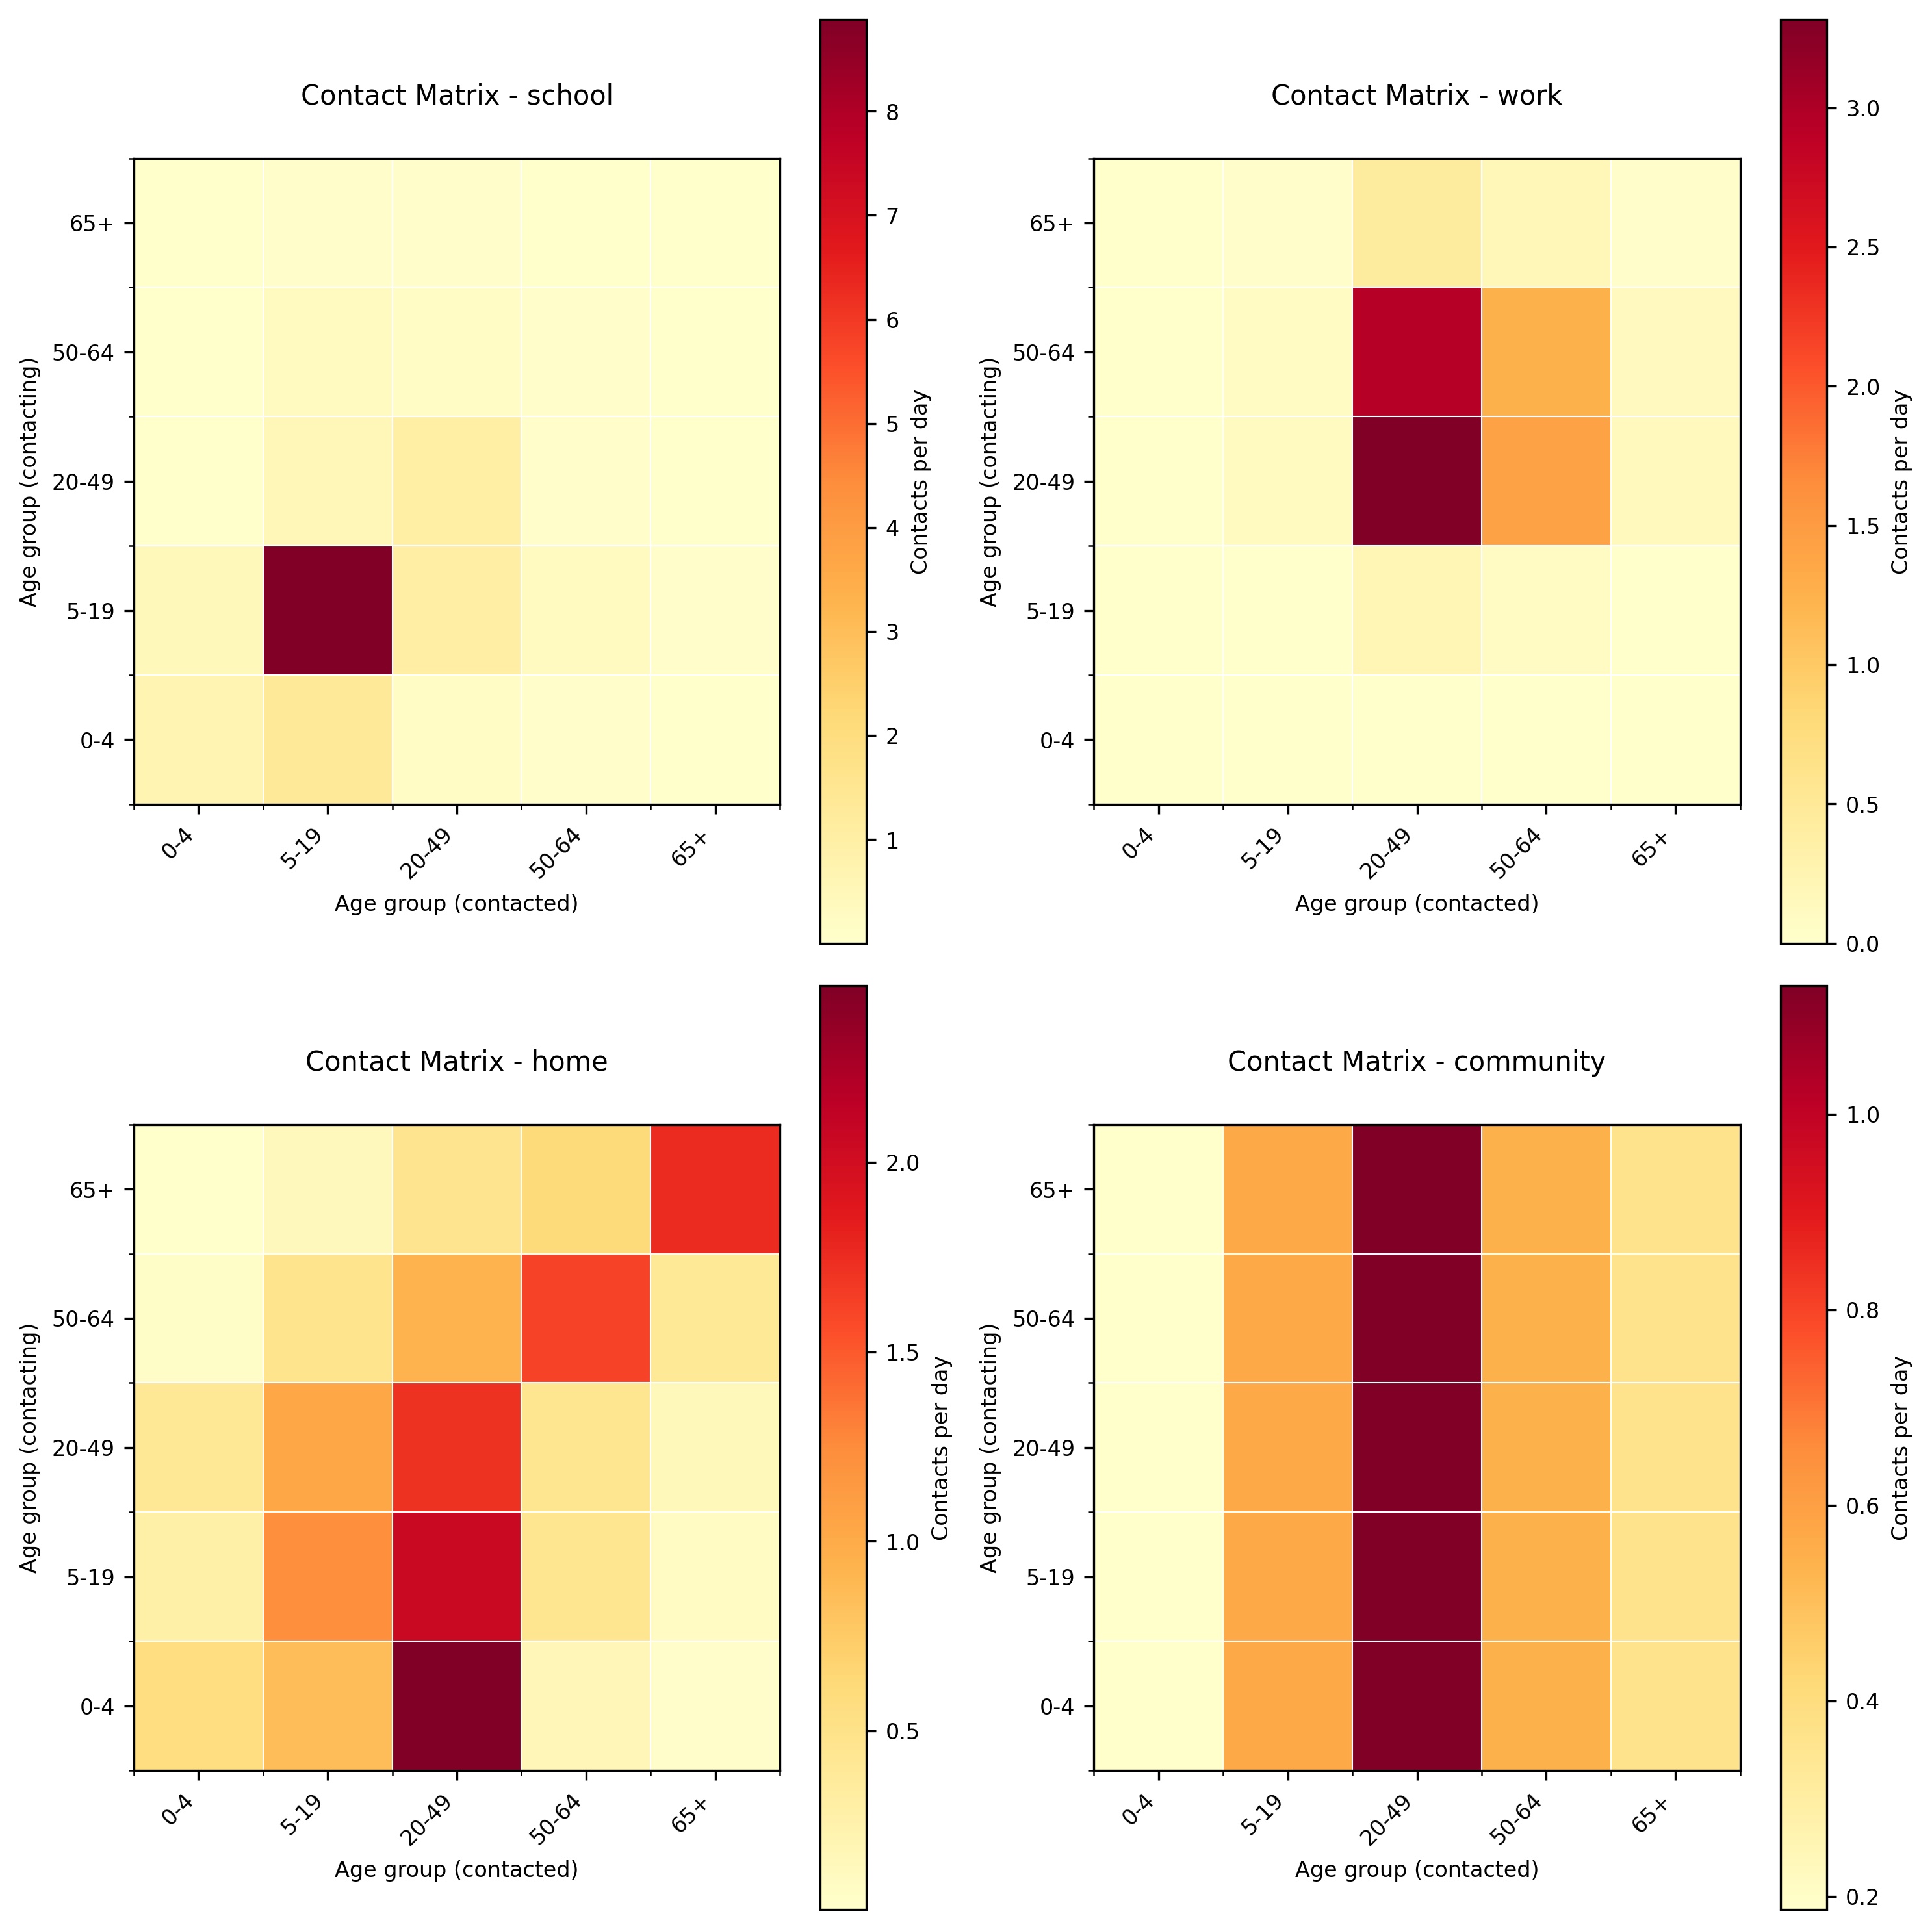

In [3]:
from epydemix.visualization import plot_contact_matrix, plot_population
import matplotlib.pyplot as plt

plot_population(population, show_perc=True)

fig, axes = plt.subplots(2, 2, dpi=300, figsize=(10, 10))
for layer, ax in zip(population.layers, axes.flat):
    plot_contact_matrix(population, layer, ax=ax)

Next, we simulate the model with fixed parameters and explore the output:

In [4]:
# simulate model 
results = model.run_simulations(start_date="2024-01-01", 
                                end_date="2024-04-30", Nsim=100, 
                                percentage_in_agents=5/population.Nk.sum())

<Axes: >

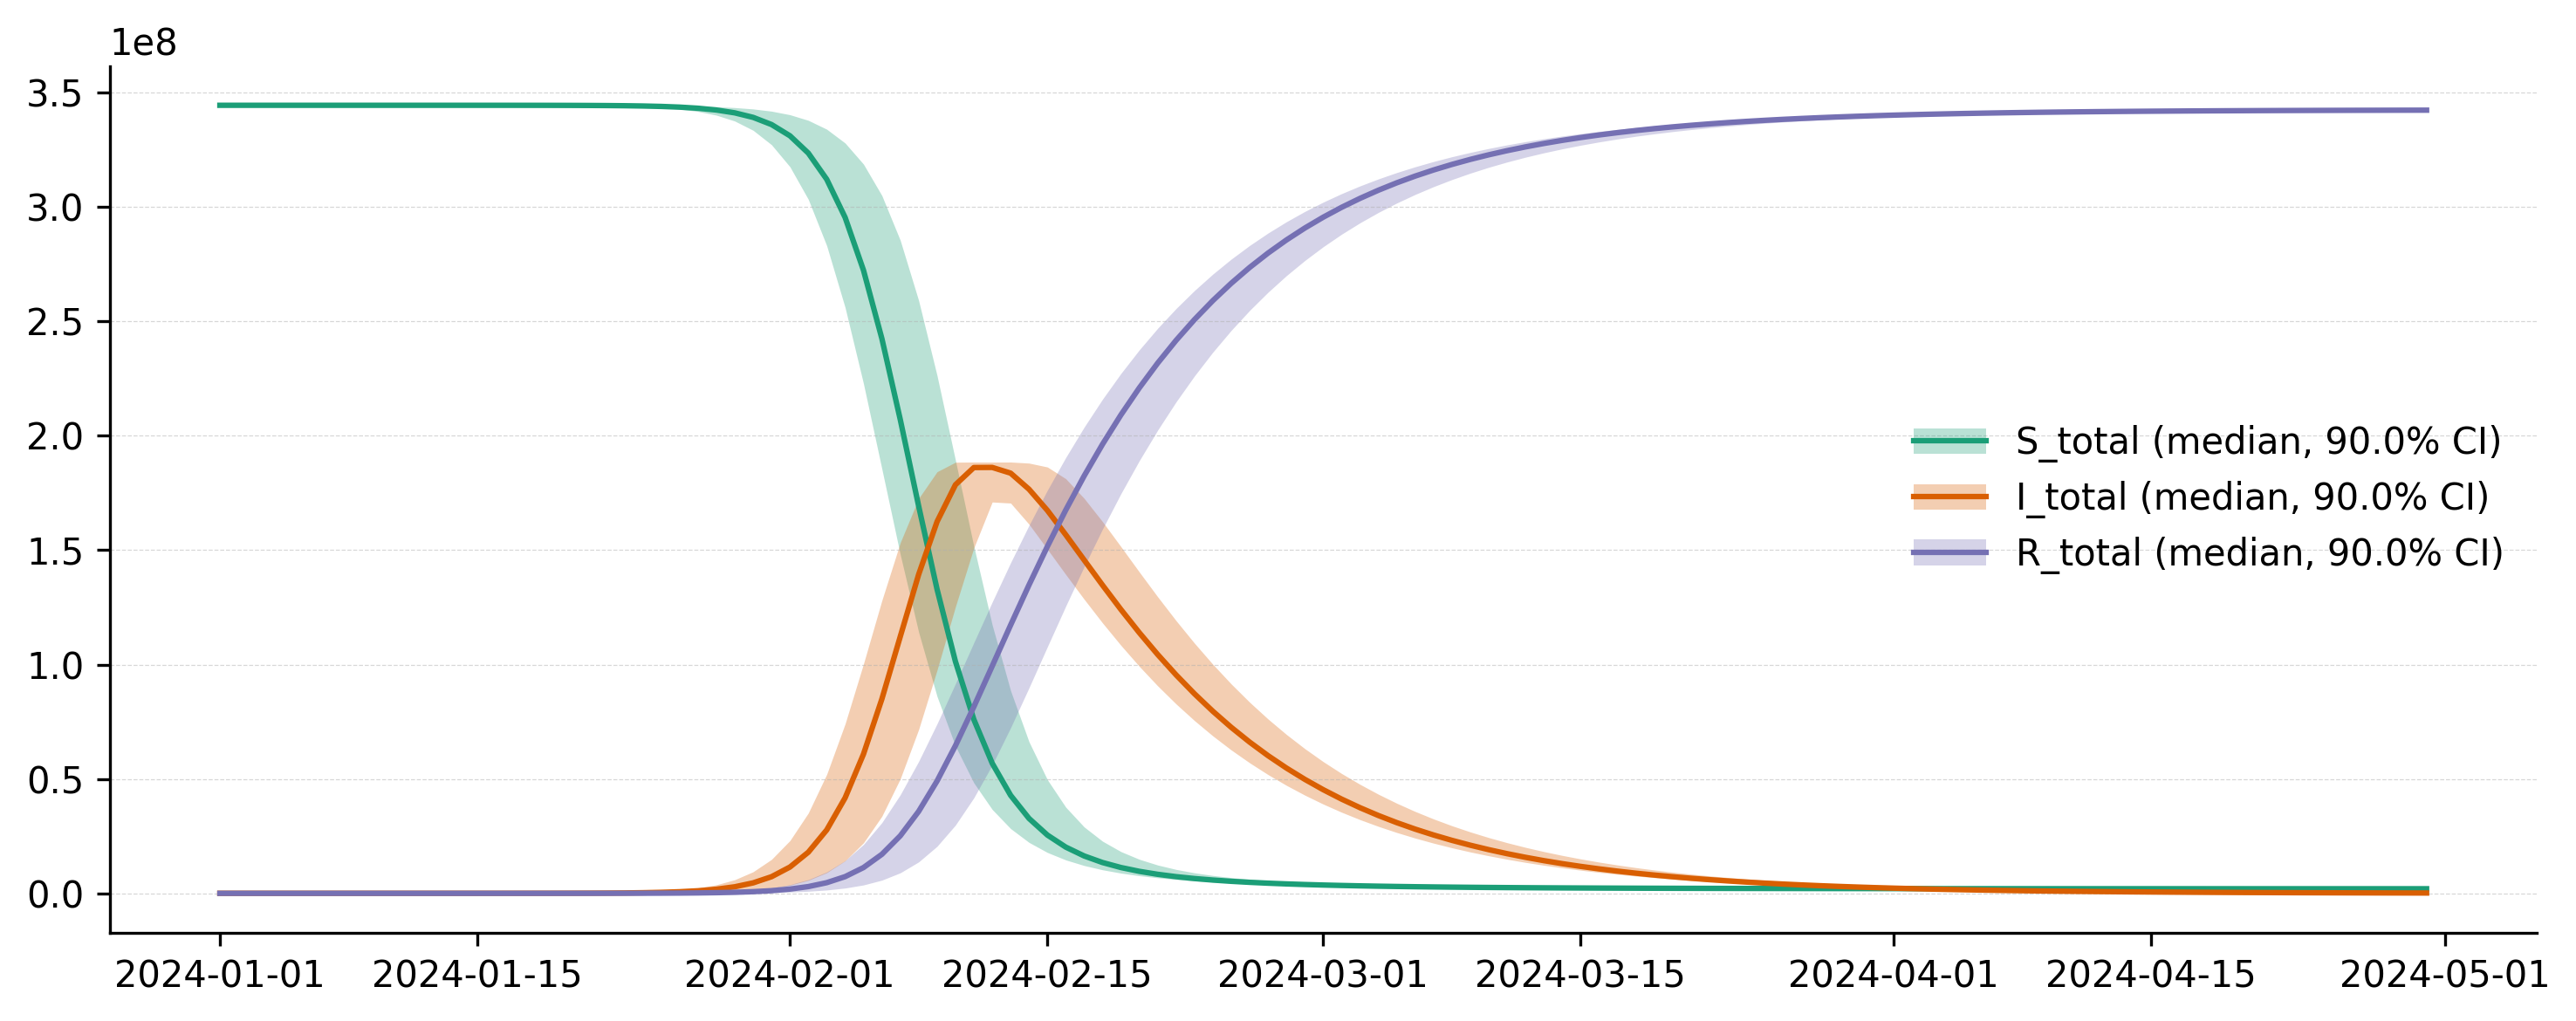

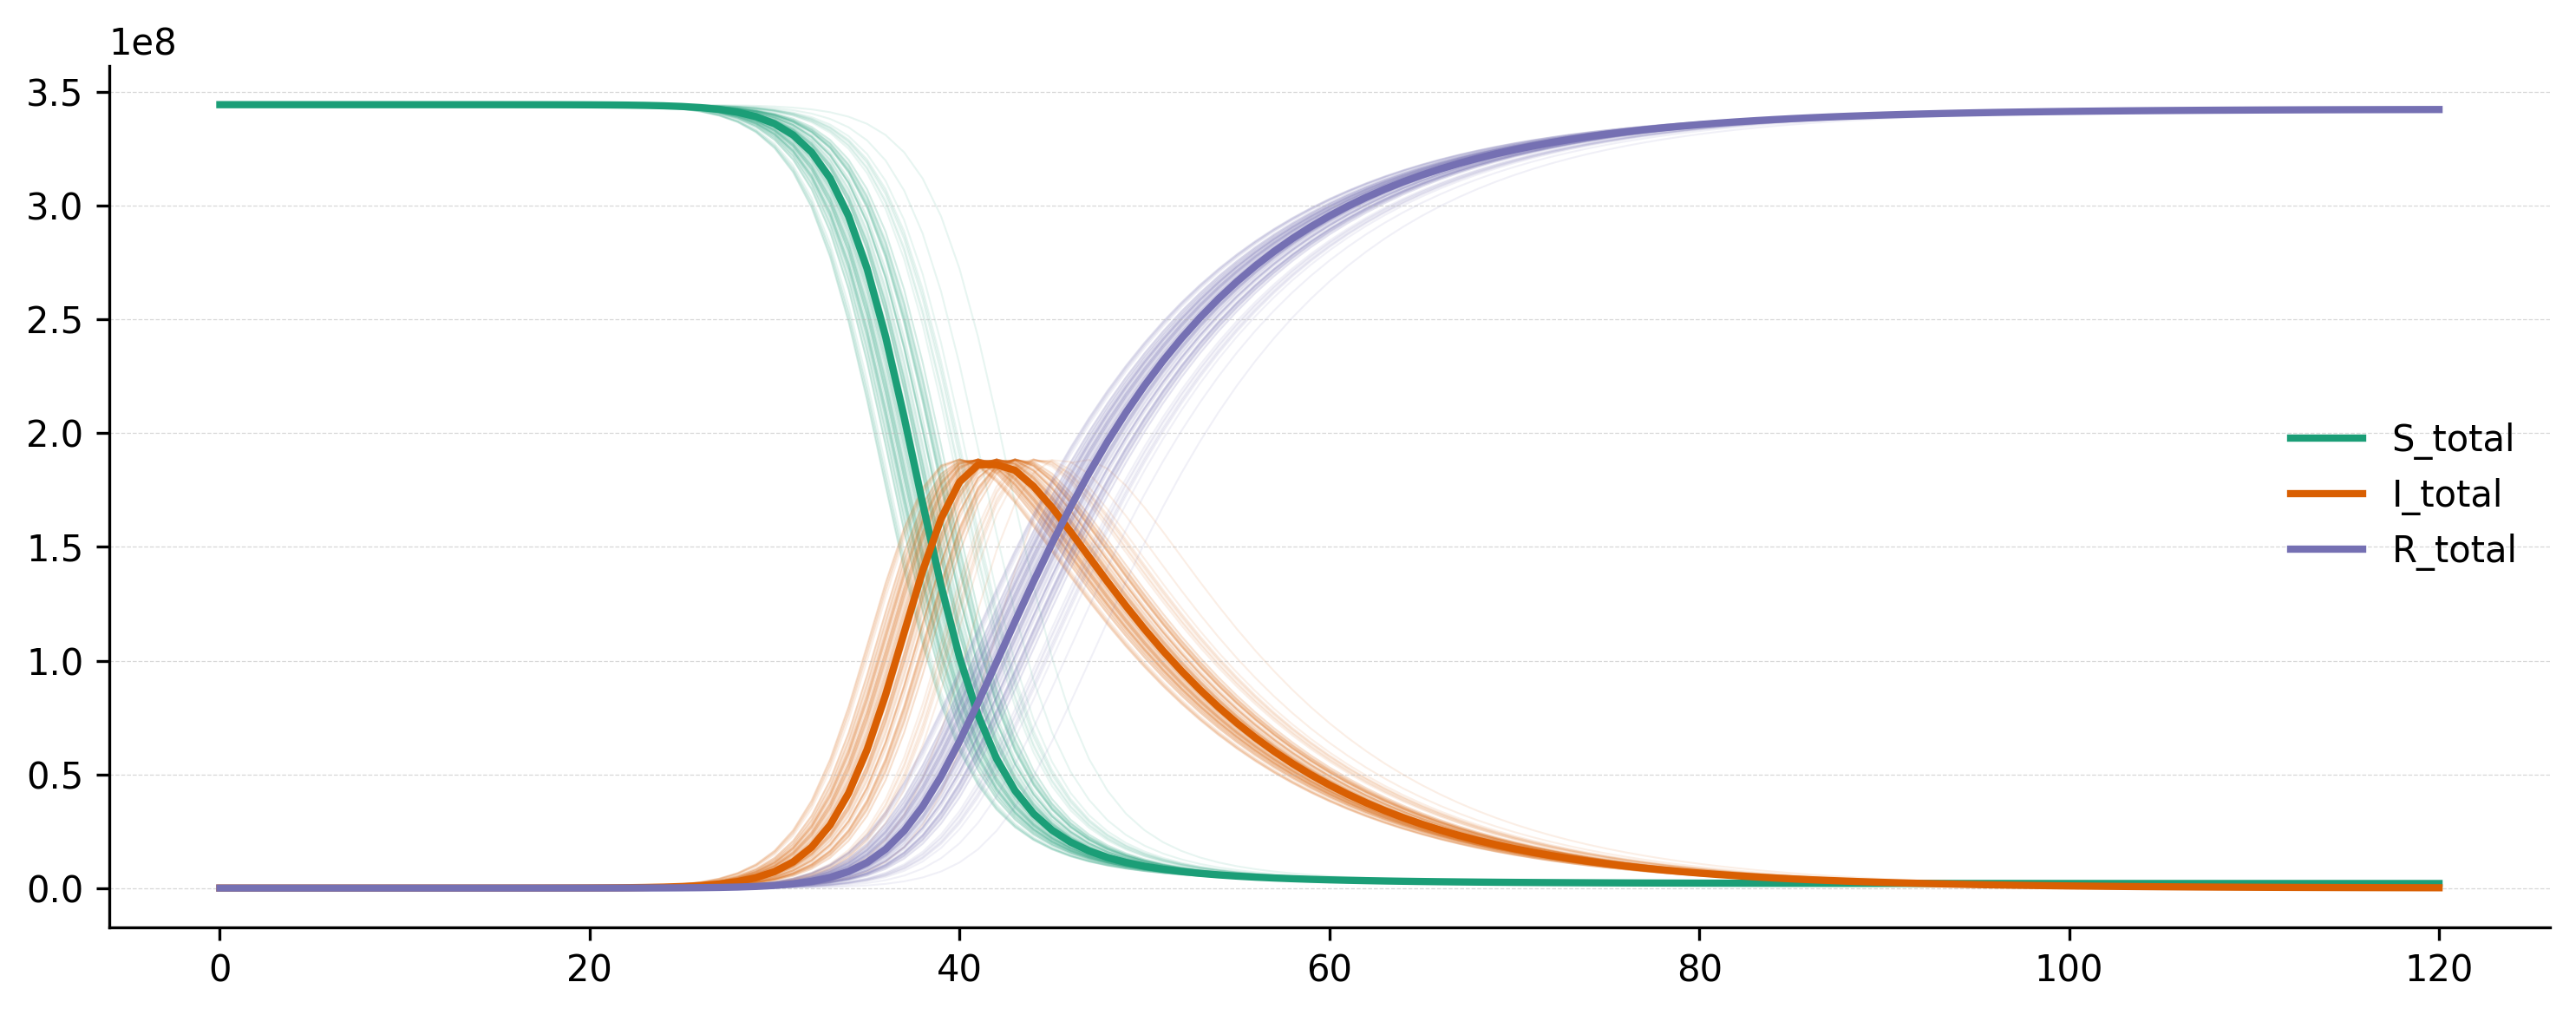

In [5]:
from epydemix.visualization import plot_quantiles, plot_trajectories

df_quantiles = results.get_quantiles_compartments()
plot_quantiles(df_quantiles, columns=['S_total', 'I_total', 'R_total'], legend_loc="center right")       

df_stacked = results.get_stacked_compartments()
plot_trajectories(df_stacked, columns=['S_total', 'I_total', 'R_total'], legend_loc="center right")       

We import synthetically generated data on new daily infections (incidence):

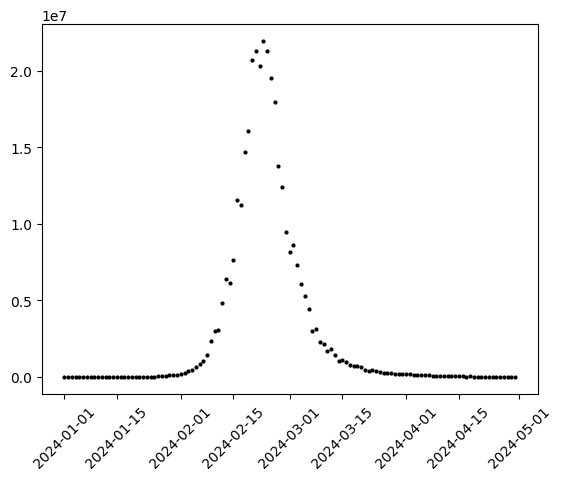

In [ ]:
import pandas as pd
data = pd.read_csv("./data/United_States_incidence.csv", parse_dates=["date"])  

plt.scatter(data['date'], data['data'], label="data", color='k', s=4)
plt.xticks(rotation=45);

We aim to calibrate our model on this data. To do this, we setup all elements needed for model calibration (priors, simulation function, etc)

In [7]:
from epydemix.calibration import ABCSampler, rmse
from epydemix.model import simulate
from epydemix.utils import compute_simulation_dates
import numpy as np
from scipy.stats import uniform

# simulation parameters
simulation_dates = compute_simulation_dates(data.date.values[0], data.date.values[-1])
parameters = {"percentage_in_agents": 5 / population.Nk.sum(),
              "epimodel": model, 
              "start_date": data.date.values[0],
              "end_date": data.date.values[-1]
              }
# define priors
priors = {"beta": uniform(0.01, 0.05)}

# define simulation wrapper
def simulate_wrapper(parameters): 
    results = simulate(**parameters)
    return {"data": results.transitions["S_to_I_total"]}


Finally, we create the ABCSampler object and we run the three ABC algorithms supported

In [8]:
# define sampler 
sampler = ABCSampler(simulation_function=simulate_wrapper, 
                     observed_data=data['data'].values, 
                     priors=priors, 
                     parameters=parameters,
                     distance_function=rmse)

- ABC-SMC

In [9]:
results_abc_smc = sampler.calibrate(strategy="smc", 
                                    num_particles=100,
                                    num_generations=5)

Starting ABC-SMC with 100 particles and 5 generations

Generation 1/5 (epsilon: inf)
	Accepted 100/100 (acceptance rate: 100.00%)
	Elapsed time: 00:00:02

Generation 2/5 (epsilon: 7051104.808820)
	Accepted 100/192 (acceptance rate: 52.08%)
	Elapsed time: 00:00:06

Generation 3/5 (epsilon: 6170720.588052)
	Accepted 100/318 (acceptance rate: 31.45%)
	Elapsed time: 00:00:09

Generation 4/5 (epsilon: 4059846.963051)
	Accepted 100/412 (acceptance rate: 24.27%)
	Elapsed time: 00:00:12

Generation 5/5 (epsilon: 2653337.948183)
	Accepted 100/290 (acceptance rate: 34.48%)
	Elapsed time: 00:00:09


- ABC Rejection

In [10]:
results_rejection = sampler.calibrate(strategy="rejection",
                                      num_particles=100, 
                                      epsilon=2000000)

Starting ABC rejection sampling with 100 particles and epsilon threshold 2000000
	Simulations: 1000, Accepted: 52, Acceptance rate: 5.20%
	Final: 100 particles accepted from 1943 simulations (5.15% acceptance rate)


- ABC Rejection with a simulation-budget constraint

In [11]:
results_top_fraction = sampler.calibrate(strategy="top_fraction",
                                         Nsim=1000,
                                         top_fraction=0.1)
                                         

Starting ABC top fraction selection with 1000 simulations and top 10.0% selected
	Selected 100 particles (top 10.0%) with distance threshold 2859014.534425


We plot data along with fitted model calibration curves and posterior distribution of the free parameter

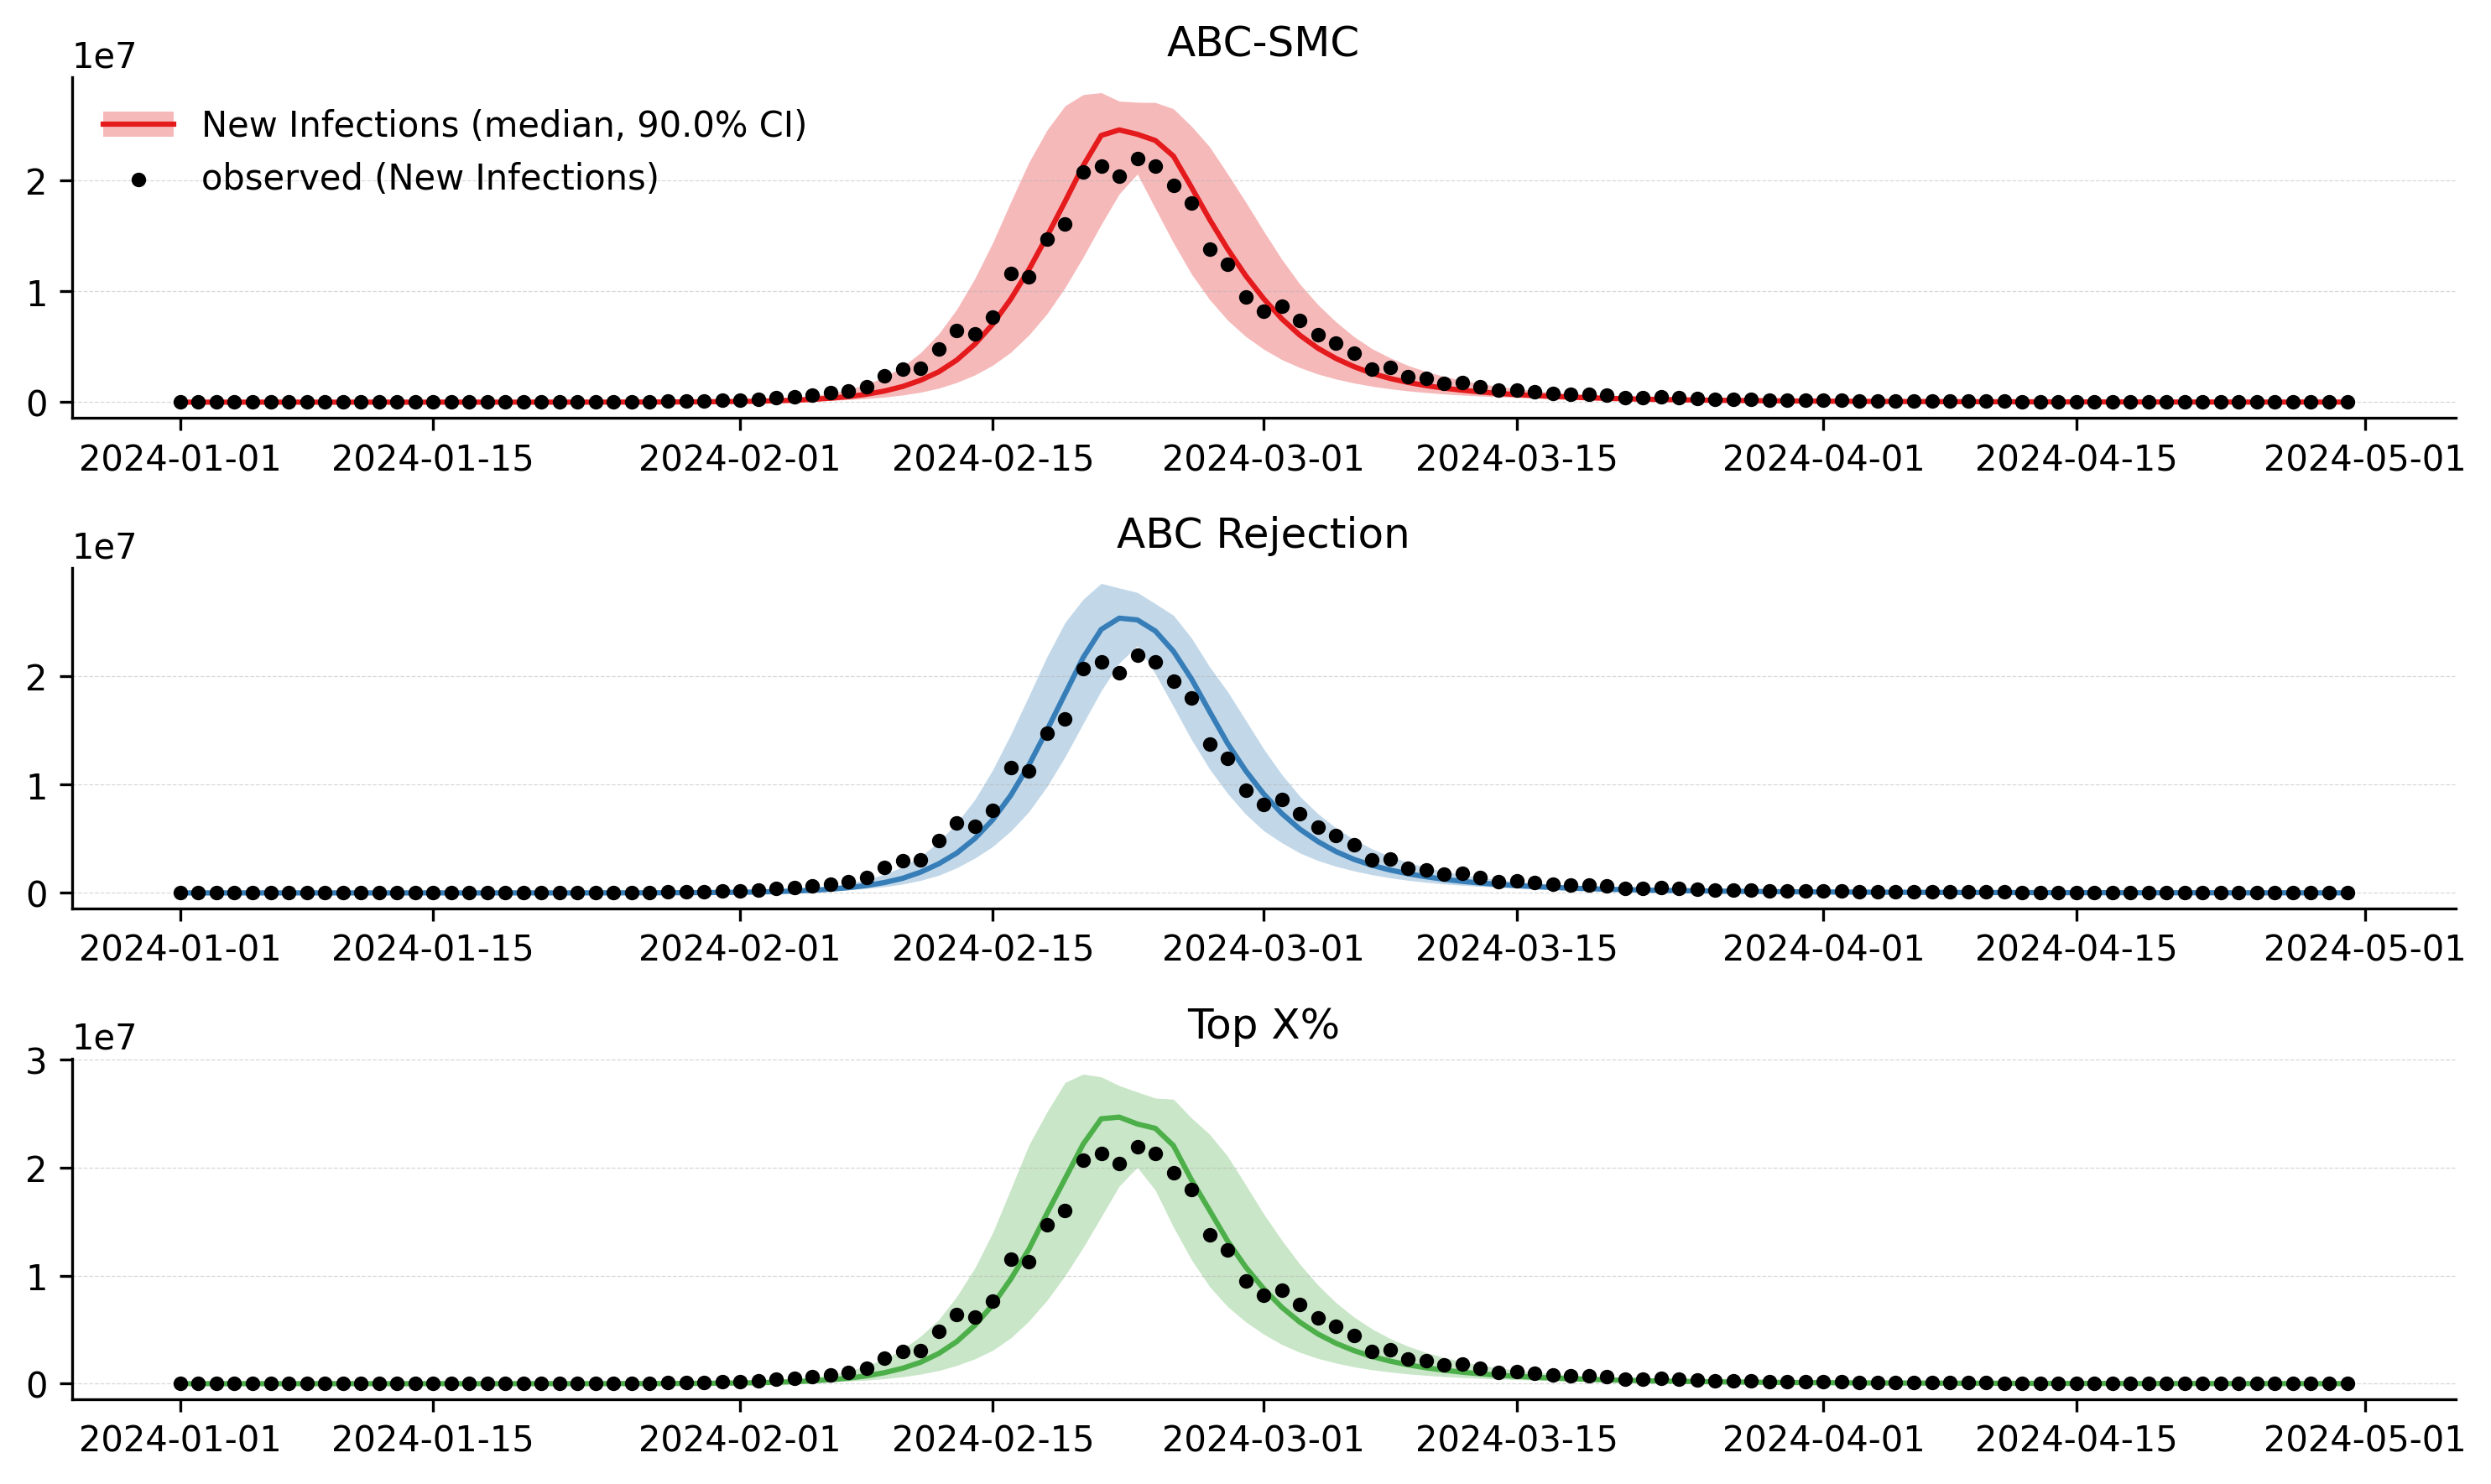

In [12]:
import seaborn as sns 
colors = sns.color_palette("Set1")

# compute quantiles 
df_quantiles_abc_smc = results_abc_smc.get_calibration_quantiles(dates=simulation_dates)
df_quantiles_abc_rejection = results_rejection.get_calibration_quantiles(dates=simulation_dates)
df_quantiles_top_perc = results_top_fraction.get_calibration_quantiles(dates=simulation_dates)

fig, axes = plt.subplots(3, 1, figsize=(10, 6), dpi=300)
plot_quantiles(df_quantiles_abc_smc, columns="data", data=data, ax=axes[0], title="ABC-SMC", colors=colors[0], show_data=True, labels=["New Infections"])   
plot_quantiles(df_quantiles_abc_rejection, columns="data", data=data, ax=axes[1], show_legend=False, title="ABC Rejection", colors=colors[1], show_data=True)
plot_quantiles(df_quantiles_top_perc, columns="data", data=data, ax=axes[2], show_legend=False, title="Top X%", colors=colors[2], show_data=True)
plt.tight_layout()

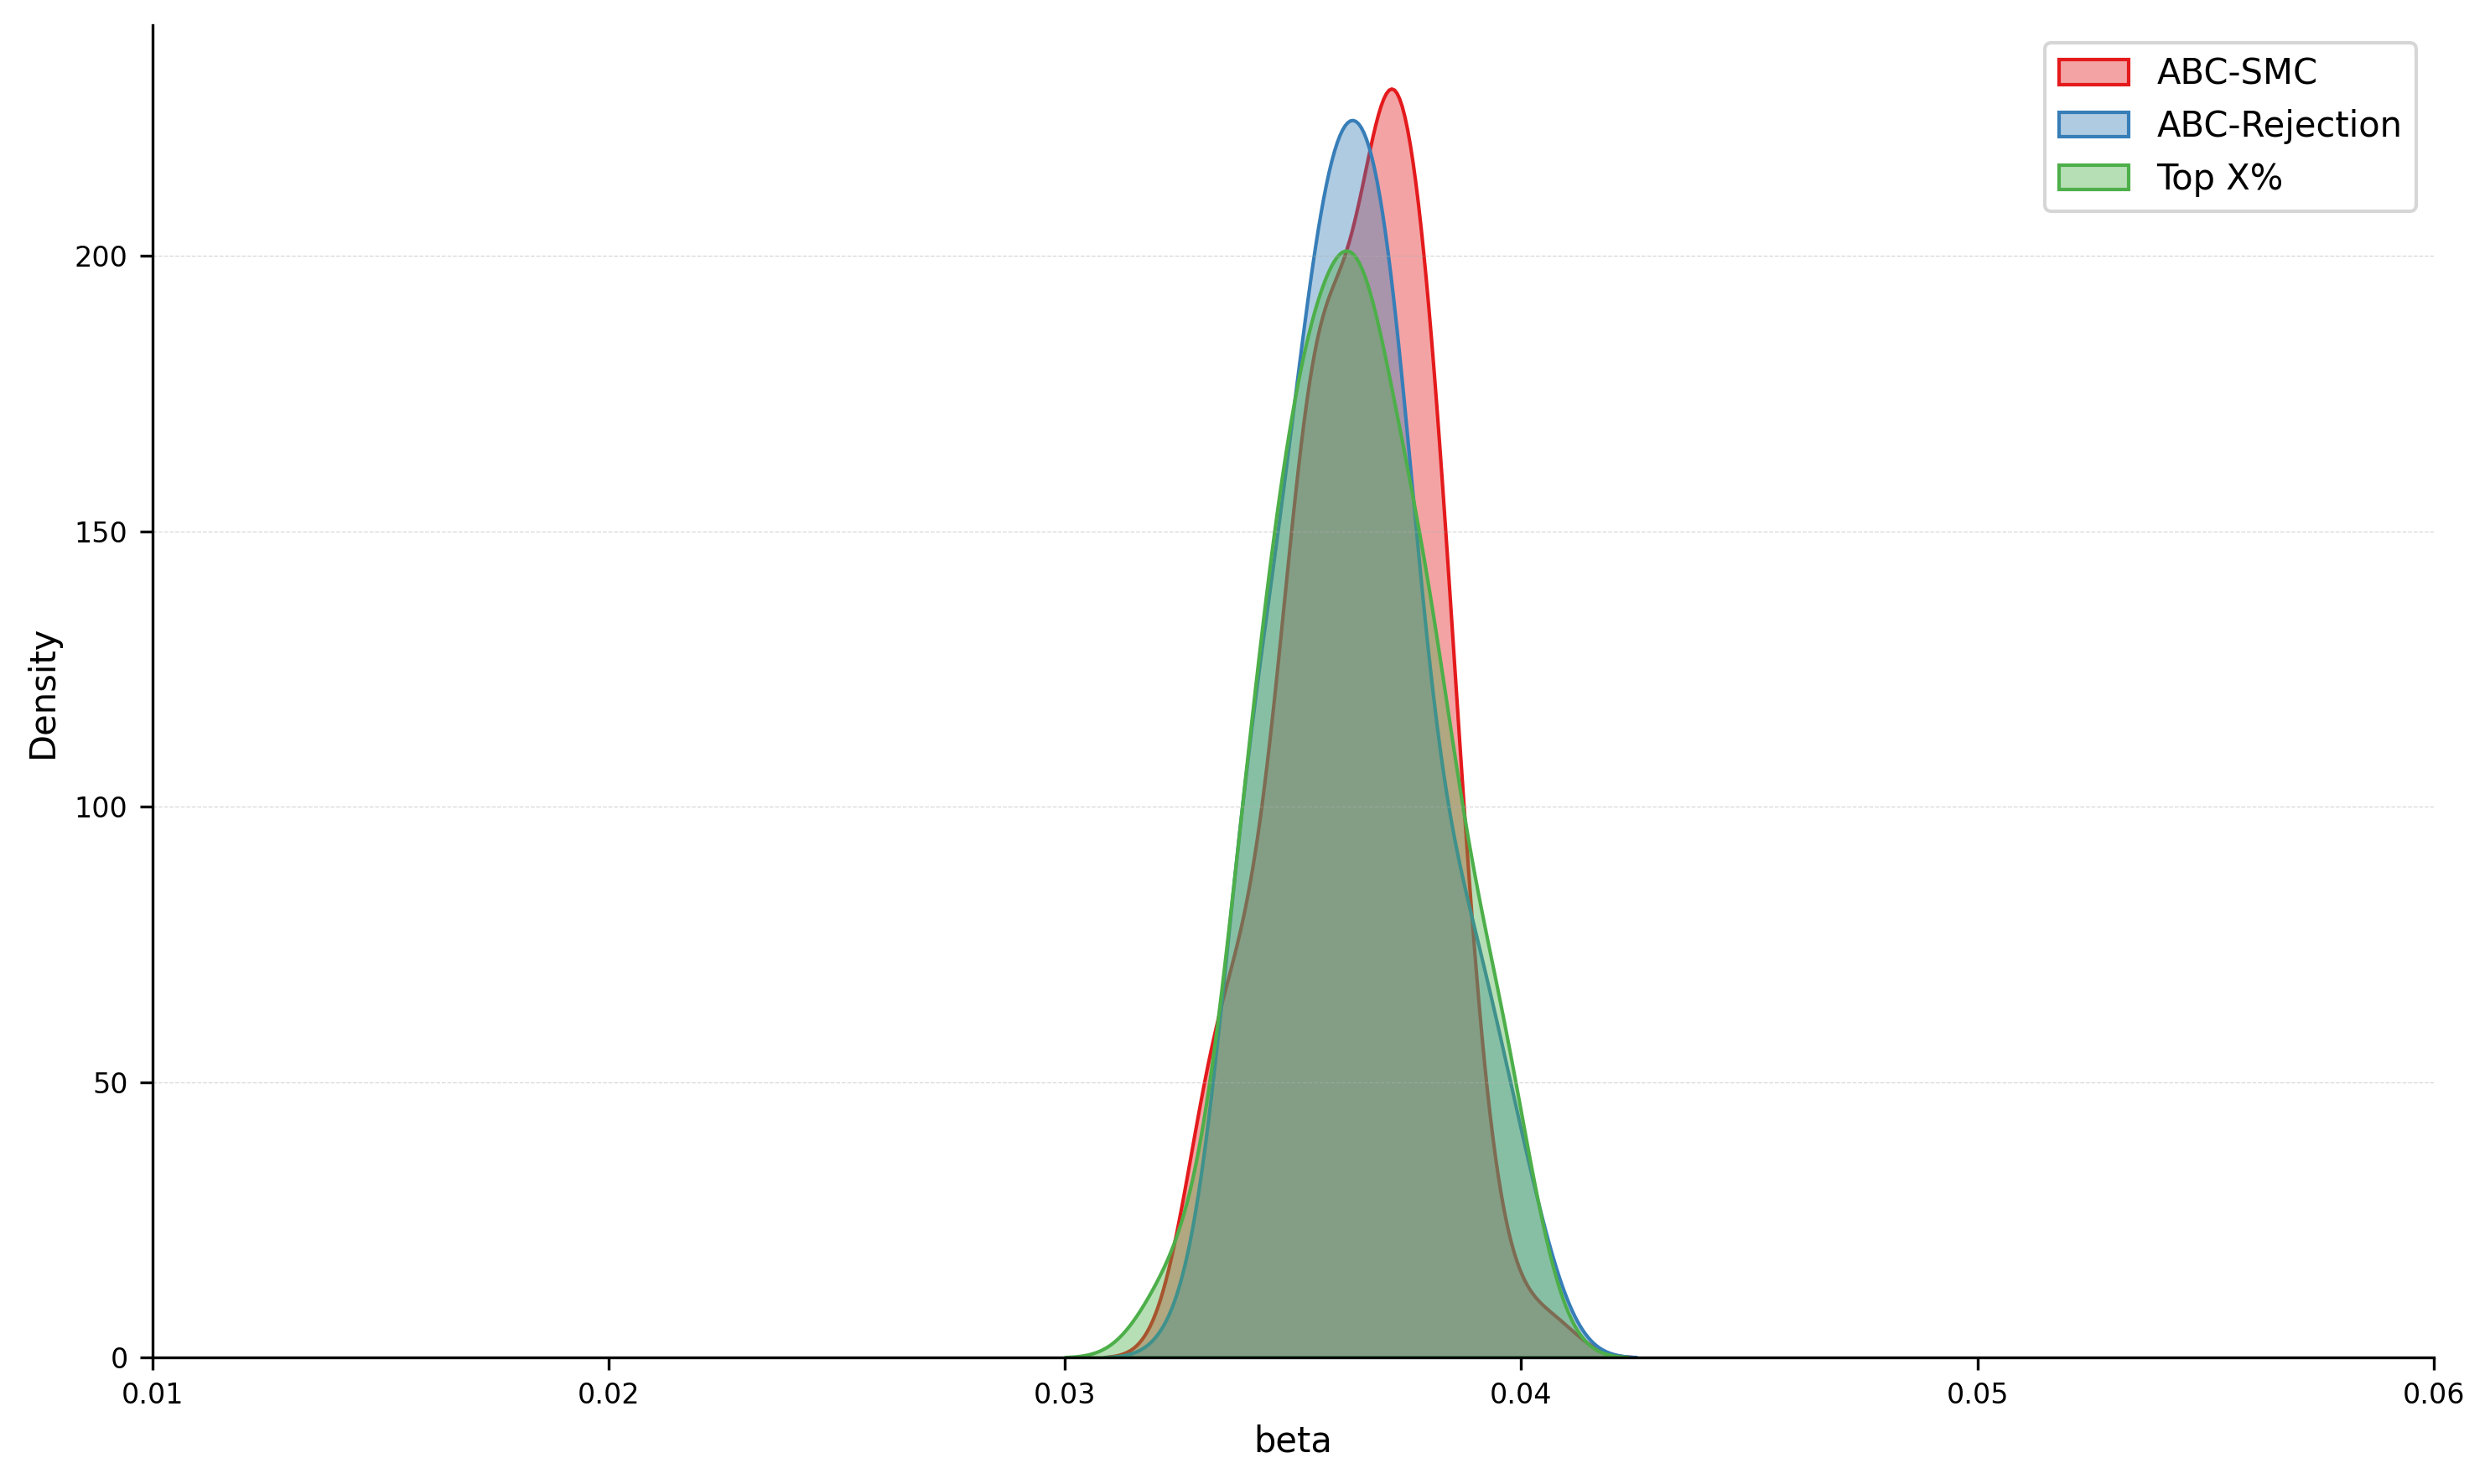

In [13]:
# explore posteriors
from epydemix.visualization import plot_posterior_distribution

df_posterior_abc_smc = results_abc_smc.get_posterior_distribution()
df_posterior_abc_rejection = results_rejection.get_posterior_distribution()
df_posterior_top_perc = results_top_fraction.get_posterior_distribution()

fig, ax = plt.subplots(figsize=(10, 6), dpi=300)
plot_posterior_distribution(df_posterior_abc_smc, parameter="beta", color=colors[0], ax=ax, label="ABC-SMC", kind="kde", prior_range=True, prior=priors["beta"])
plot_posterior_distribution(df_posterior_abc_rejection, parameter="beta", color=colors[1], ax=ax, label="ABC-Rejection", kind="kde", prior_range=True, prior=priors["beta"])
plot_posterior_distribution(df_posterior_top_perc, parameter="beta", color=colors[2], ax=ax, label="Top X%", kind="kde", prior_range=True, prior=priors["beta"])
ax.legend()